In [12]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define directories and classes
source_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/thermal images UL"
output_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/processed_data_Unet"
classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

In [4]:
def prepare_data(source_dir, output_dir, classes, train_split=0.7, val_split=0.15):
    """Splits dataset into train, validation, and test while handling missing files."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for split in ['train', 'validation', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        if not os.path.exists(class_path):
            print(f"Skipping {cls}: No such directory {class_path}")
            continue

        images = [img for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
        if len(images) == 0:
            print(f"Skipping {cls}: No images found")
            continue

        np.random.shuffle(images)
        train_count = int(len(images) * train_split)
        val_count = int(len(images) * val_split)

        for i, img in enumerate(images):
            src = os.path.join(class_path, img)
            if i < train_count:
                dst = os.path.join(output_dir, 'train', cls, img)
            elif i < train_count + val_count:
                dst = os.path.join(output_dir, 'validation', cls, img)
            else:
                dst = os.path.join(output_dir, 'test', cls, img)

            shutil.copy(src, dst)

In [5]:
def calculate_class_weights(directory):
    """Calculate class weights to handle class imbalance."""
    total_samples = 0
    class_samples = {}

    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, 'train', cls)
        if not os.path.exists(class_path):
            print(f"Warning: {cls} folder is missing in training data.")
            continue

        num_samples = len(os.listdir(class_path))
        class_samples[i] = num_samples
        total_samples += num_samples

    class_weights = {i: total_samples / (len(classes) * count) for i, count in class_samples.items() if count > 0}
    return class_weights

In [6]:
def create_data_generators(output_dir, img_size=(224, 224), batch_size=16):
    """Creates ImageDataGenerators with optimized augmentations."""
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,  # Reduce excessive rotation
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [9]:
def build_unet_model(input_shape=(224, 224, 3), num_classes=6):
    """Builds a U-Net inspired model optimized for classification."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bridge
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Classifier
    gap = layers.GlobalAveragePooling2D()(conv3)
    dense1 = layers.Dense(128, activation='relu')(gap)
    dropout = layers.Dropout(0.5)(dense1)
    outputs = layers.Dense(num_classes, activation='softmax')(dropout)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
if __name__ == "__main__":
    # Prepare data (ensure missing files are handled)
    prepare_data(source_directory, output_directory, classes)

    # Create data generators
    train_gen, val_gen, test_gen = create_data_generators(output_directory)

    # Compute class weights
    class_weights = calculate_class_weights(output_directory)

    # Build the model
    model = build_unet_model()

    # Train the model with optimized settings
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,  # Reduce epochs for faster training
        batch_size=16,
        class_weight=class_weights,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.h5', save_best_only=True, monitor='val_accuracy'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
            )
        ]
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

Found 581 images belonging to 6 classes.
Found 167 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.3068 - loss: 2.1943

37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 734ms/step - accuracy: 0.3073 - loss: 2.1927 - val_accuracy: 0.3533 - val_loss: 1.6514 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.3759 - loss: 1.9914 - val_accuracy: 0.3533 - val_loss: 1.6316 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.3665 - loss: 1.9569 - val_accuracy: 0.3533 - val_loss: 1.6009 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.3444 - loss: 1.8931 - val_accuracy: 0.3533 - val_loss: 1.5639 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3395 - loss: 1.8790

37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.3392 - loss: 1.8785 - val_accuracy: 0.3713 - val_loss: 1.5609 - learning_rate: 1.0000e-04
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.3588 - loss: 1.8122 - val_accuracy: 0.3473 - val_loss: 1.5380 - learning_rate: 1.0000e-04
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3066 - loss: 1.7807

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.3074 - loss: 1.7816 - val_accuracy: 0.3952 - val_loss: 1.5332 - learning_rate: 1.0000e-04
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.3319 - loss: 1.8369 - val_accuracy: 0.3533 - val_loss: 1.5304 - learning_rate: 1.0000e-04
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.3414 - loss: 1.7436 - val_accuracy: 0.3593 - val_loss: 1.5130 - learning_rate: 1.0000e-04
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.3554 - loss: 1.7373 - val_accuracy: 0.3892 - val_loss: 1.5261 - learning_rate: 1.0000e-04
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - accuracy: 0.3242 - loss: 1.7560 - val_accuracy: 0.3772 - val_loss: 1.5648 - learning_rate: 1.0000e-04
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.3580 - loss: 1.7780 - val_accuracy: 0.3713 - val_loss: 1.5635 - learning_rate: 1.0000e-04
Epoch 13/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.3869 - loss: 1.6638 - val_accuracy: 0.4431 - val_loss: 1.4230 - learning_rate: 5.0000e-05
Epoch 24/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3992 - loss: 1.5948

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.3990 - loss: 1.5954 - val_accuracy: 0.4491 - val_loss: 1.3920 - learning_rate: 5.0000e-05
Epoch 25/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4437 - loss: 1.6093

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.4428 - loss: 1.6095 - val_accuracy: 0.4611 - val_loss: 1.3703 - learning_rate: 5.0000e-05
Epoch 26/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.3920 - loss: 1.6300 - val_accuracy: 0.4611 - val_loss: 1.3757 - learning_rate: 5.0000e-05
Epoch 27/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.4388 - loss: 1.5761 - val_accuracy: 0.4611 - val_loss: 1.4199 - learning_rate: 5.0000e-05
Epoch 28/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.4620 - loss: 1.5518 - val_accuracy: 0.4551 - val_loss: 1.3875 - learning_rate: 5.0000e-05
Epoch 29/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4006 - loss: 1.6031

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.4012 - loss: 1.6024 - val_accuracy: 0.5090 - val_loss: 1.3601 - learning_rate: 2.5000e-05
Epoch 30/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4677 - loss: 1.5669

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.4668 - loss: 1.5676 - val_accuracy: 0.5269 - val_loss: 1.3247 - learning_rate: 2.5000e-05
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 623ms/step - accuracy: 0.5201 - loss: 1.3937

Test Accuracy: 0.5057


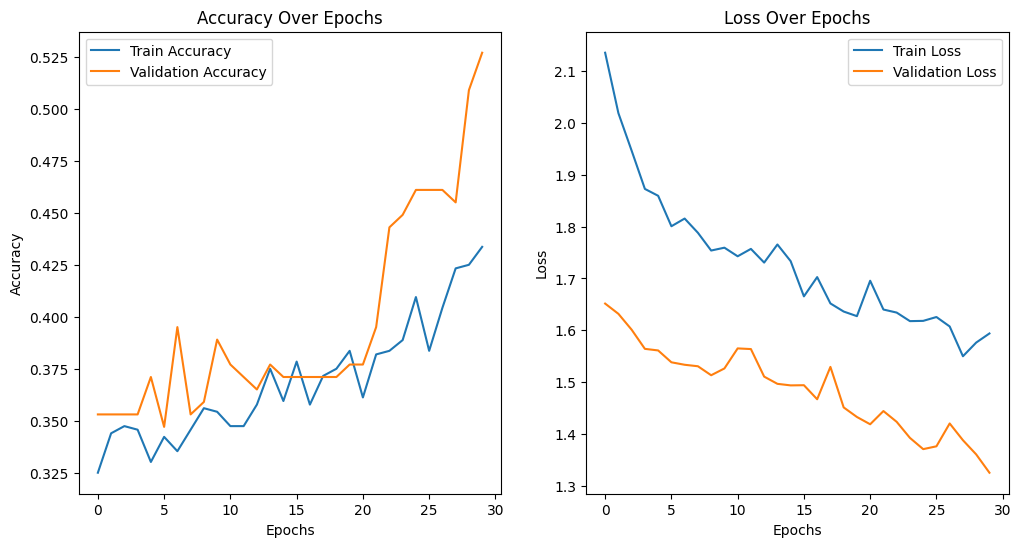

In [13]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [14]:
# Save the model
model.save("Unet.h5")
print("Model saved.")

Model saved.
